# FICO HELOC Modeling
https://community.fico.com/s/explainable-machine-learning-challenge

### Load libraries

In [1]:
import os
import numpy as np
import pandas as pd
# Scikit-learn library for machine learning models
import sklearn as sk
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
# Libraries for graphics
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

We are interested in predicting a binary variable called RiskPerformance. The value “Bad” indicates that a consumer was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. The predictor variables are all quantitative or categorical, and come from anonymized credit bureau data.

In [2]:
df = pd.read_csv('./Data/heloc_dataset_v1.csv') # FICO Home Equity Line of Credit (HELOC) Dataset 

# The target variable to predict is a binary variable called RiskPerformance. 
target_variable = 'RiskPerformance' 
target_names = ['Good', 'Bad']

# Create standardized target varibale column
df.loc[df[target_variable]==target_names[0],'Class'] = 0
df.loc[df[target_variable]==target_names[1],'Class'] = 1
df['Class'] = df['Class'].astype(int)
df[target_variable] = df[target_variable].astype('category')

# Feature variables
features = list(df.columns)
features.remove(target_variable)
features.remove('Class')

# Count of categorical variable
df.groupby(target_variable)[target_variable].count() 

RiskPerformance
Bad     5459
Good    5000
Name: RiskPerformance, dtype: int64

### Data cleaning and visualization
Fortunately the dataset provided by FICO is relatively clean and the sample is already "balanced." While we can (and probably should) devote a whole post to just talking about data cleaning and transformation (e.g., binning), let's instead focus on analyzing and presenting some of the most important characteristics of the data.

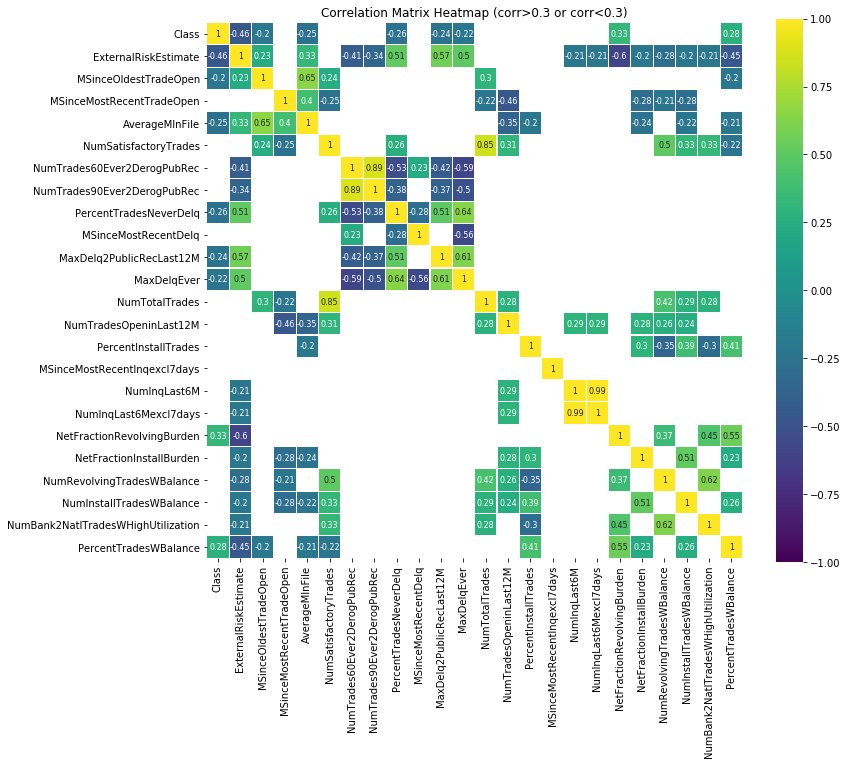

In [3]:
# Exclude records with missing score values
df = df[df['ExternalRiskEstimate']!=-9] 

# Correlations for numerical variables
df_corr = df[['Class'] + features].corr() #Point Biserial Correlation btw Class and feature variables

# Top feature variables based on absolute correlations
df_corr2 = pd.DataFrame({'corr': df_corr['Class'], 'abs_corr': abs(df_corr['Class'])})
df_corr2.sort_values(by = 'abs_corr', ascending=False, inplace=True)
features_sub = list(df_corr2.iloc[1:16].index)

# Visualize the correlations
plt.figure(figsize=(12, 10))
plt.title('Correlation Matrix Heatmap (corr>0.3 or corr<0.3)')
sns.heatmap(df_corr[(df_corr >= 0.2) | (df_corr <= -0.2)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

We summarize below the top features based on the correlation matrix, and include the monotonicity constraints given by FICO in parenthesis:
* ExternalRiskEstimate: Consolidated version of risk markers (-)
* NetFractionRevolvingBurden: Net Fraction Revolving Burden. This is revolving balance divided by credit limit (+)
* PercentTradesWBalance: Percent Trades with Balance (+/-)
* PercentTradesNeverDelq: Percent Trades Never Delinquent (-)
* AverageMInFile: Average Months in File (-)
* MaxDelq2PublicRecLast12M: Max Delq/Public Records Last 12 Months.  (-)
* MaxDelqEver: Max Delinquency Ever.  (-)
* MSinceOldestTradeOpen: Months Since Oldest Trade Open (-)

The results appear to be consistent with the FICO's contraints on correlations with the target variable.

Below are additional data plots to visualize the relationship between the target variable and feature variables. While only boxplots are included here as an example, additional helpful techinques can be found in the full code.

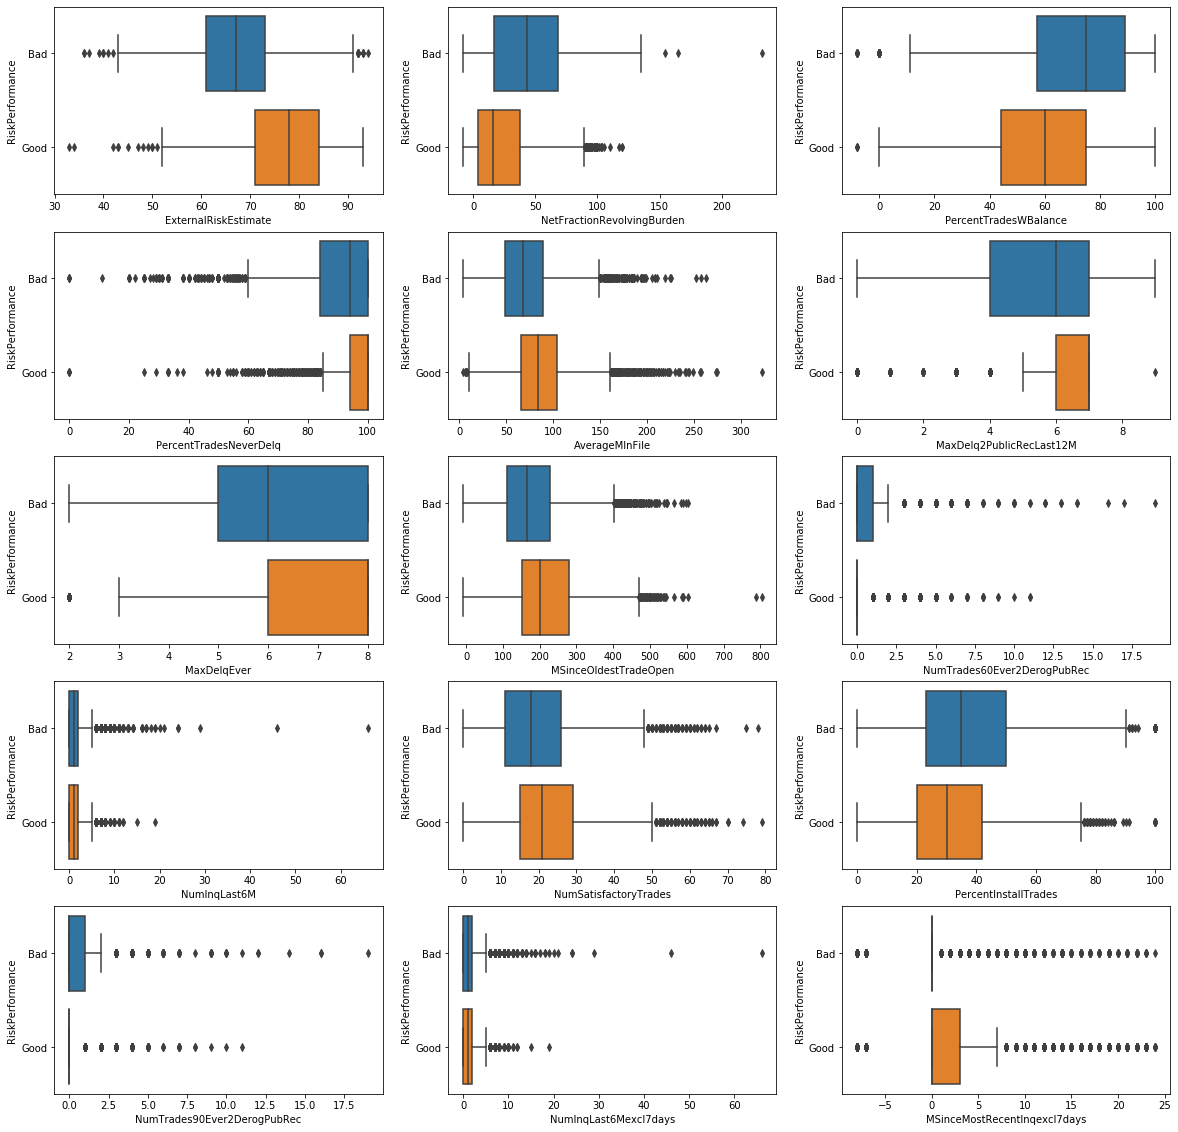

In [4]:
# Box plot
n_rows = 5
n_cols = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 20))
for i in list(range(0, n_rows)):
    for j in list(range(0, n_cols)):
        k = (i*n_cols)+j
        if k<len(features_sub):
            sns.boxplot(x=features_sub[k], y=target_variable, data=df, ax=axes[i, j])


### Predictive modeling using machine learning classification algorithms

Here we are going to explore two commonly used algorithms: descicion tree and random forest models. As these are merely straw-man versions for illustration purpose, our focus is to present how these models can be developed, calibrated, and validated in Python. 

Let's first define a function that would be helpful in reporting model performance, and split the data into training and testing sets.

In [5]:
# Print summary for out-of-sample model perforamce
def model_summary(y_test, dtc_predict, dtc_cv_score):
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, dtc_predict))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, dtc_predict))
    print('\n')
    print("=== All AUC Scores ===")
    print(dtc_cv_score)
    print('\n')
    print("=== Mean AUC Score ===")
    print("Mean AUC Score: ", dtc_cv_score.mean())

#Define predcitors and target variable
X = df[features].copy() 
y = df['Class'].copy()

# Implement train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

#### Decision tree model
Decision tree learning is one of the predictive modeling approaches used in statistics, data mining and machine learning. It uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item’s target value (represented in the leaves). Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

First, let's create a simple tree model using 5 as the maximum depth of the tree. We then use the fitted model to predict the data and report the model performance.

In [6]:
# Preliminary model fit
dtc = tree.DecisionTreeClassifier(max_depth=5)
dtc = dtc.fit(X_train, y_train)
dtc_predict = dtc.predict(X_test) # predictions
dtc_cv_score = cross_val_score(dtc, X, y, cv=10, scoring='roc_auc') #scores
model_summary(y_test, dtc_predict, dtc_cv_score) # Model summary

=== Confusion Matrix ===
[[1027  529]
 [ 413 1286]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.71      0.66      0.69      1556
           1       0.71      0.76      0.73      1699

    accuracy                           0.71      3255
   macro avg       0.71      0.71      0.71      3255
weighted avg       0.71      0.71      0.71      3255



=== All AUC Scores ===
[0.77189076 0.75231713 0.7972318  0.75814654 0.78274792 0.81437385
 0.77472604 0.71600336 0.78445164 0.79885697]


=== Mean AUC Score ===
Mean AUC Score:  0.775074601999759


Next we will fine tune the model by finding the optimal parameter settings. In this case, we search for the best tree depth parameter using the entropy as the criterion.

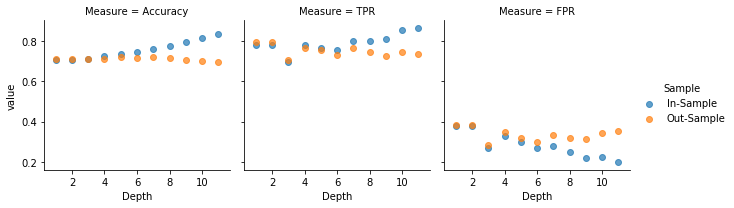

In [7]:
# Search for best depth parameter for decision tree model
def tree_depth_search (X_train, X_test, y_train, y_test, criterion, depth_range):
    dt2 = pd.DataFrame()
    for i in depth_range:
        
        clf = tree.DecisionTreeClassifier(criterion=criterion, max_depth=i, random_state=66)
        clf = clf.fit(X_train,y_train)
        out_sample_pred = clf.predict(X_test)
        in_sample_pred = clf.predict(X_train)
        in_acc = sk.metrics.accuracy_score(y_train, in_sample_pred)
        out_acc = sk.metrics.accuracy_score(y_test, out_sample_pred)
        in_conf = sk.metrics.confusion_matrix(y_train, in_sample_pred)
        out_conf = sk.metrics.confusion_matrix(y_test, out_sample_pred)
        tpr_in = in_conf[1][1]/(in_conf[1][0]+in_conf[1][1])
        tpr_out = out_conf[1][1]/(out_conf[1][0]+out_conf[1][1])
        fpr_in = in_conf[0][1]/(in_conf[0][0]+in_conf[0][1])
        fpr_out = out_conf[0][1]/(out_conf[0][0]+out_conf[0][1])
        
        dt1 = pd.DataFrame({'Depth': [i, i], 'Sample': ['In-Sample', 'Out-Sample'], 'Accuracy': [in_acc, out_acc],
                            "TPR": [tpr_in,tpr_out], "FPR": [fpr_in, fpr_out]})
        dt2 = pd.concat([dt2, dt1])
   
    return dt2

dtc_depth = tree_depth_search(X_train, X_test, y_train, y_test, criterion='entropy', depth_range=range(1, 12))

## Plot the model measures
dt1 = pd.melt(dtc_depth, id_vars=['Depth', 'Sample'], var_name='Measure') #Reshape data
g = sns.FacetGrid(dt1, col='Measure', hue='Sample')
g.map(plt.scatter, "Depth", "value",  alpha=.7)
g.add_legend(title=None);

It appears that a max_depth of 4 can achieve reasonably good model performance when measured by accuracy, true positive rate, and false positive rate. We then refit the model here and visualize the final tree model:

=== Confusion Matrix ===
[[1017  539]
 [ 393 1306]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.72      0.65      0.69      1556
           1       0.71      0.77      0.74      1699

    accuracy                           0.71      3255
   macro avg       0.71      0.71      0.71      3255
weighted avg       0.71      0.71      0.71      3255



=== All AUC Scores ===
[0.76675221 0.75216465 0.78474257 0.75669589 0.77972297 0.81135302
 0.76907591 0.71080243 0.7872742  0.79297493]


=== Mean AUC Score ===
Mean AUC Score:  0.7711558779975239


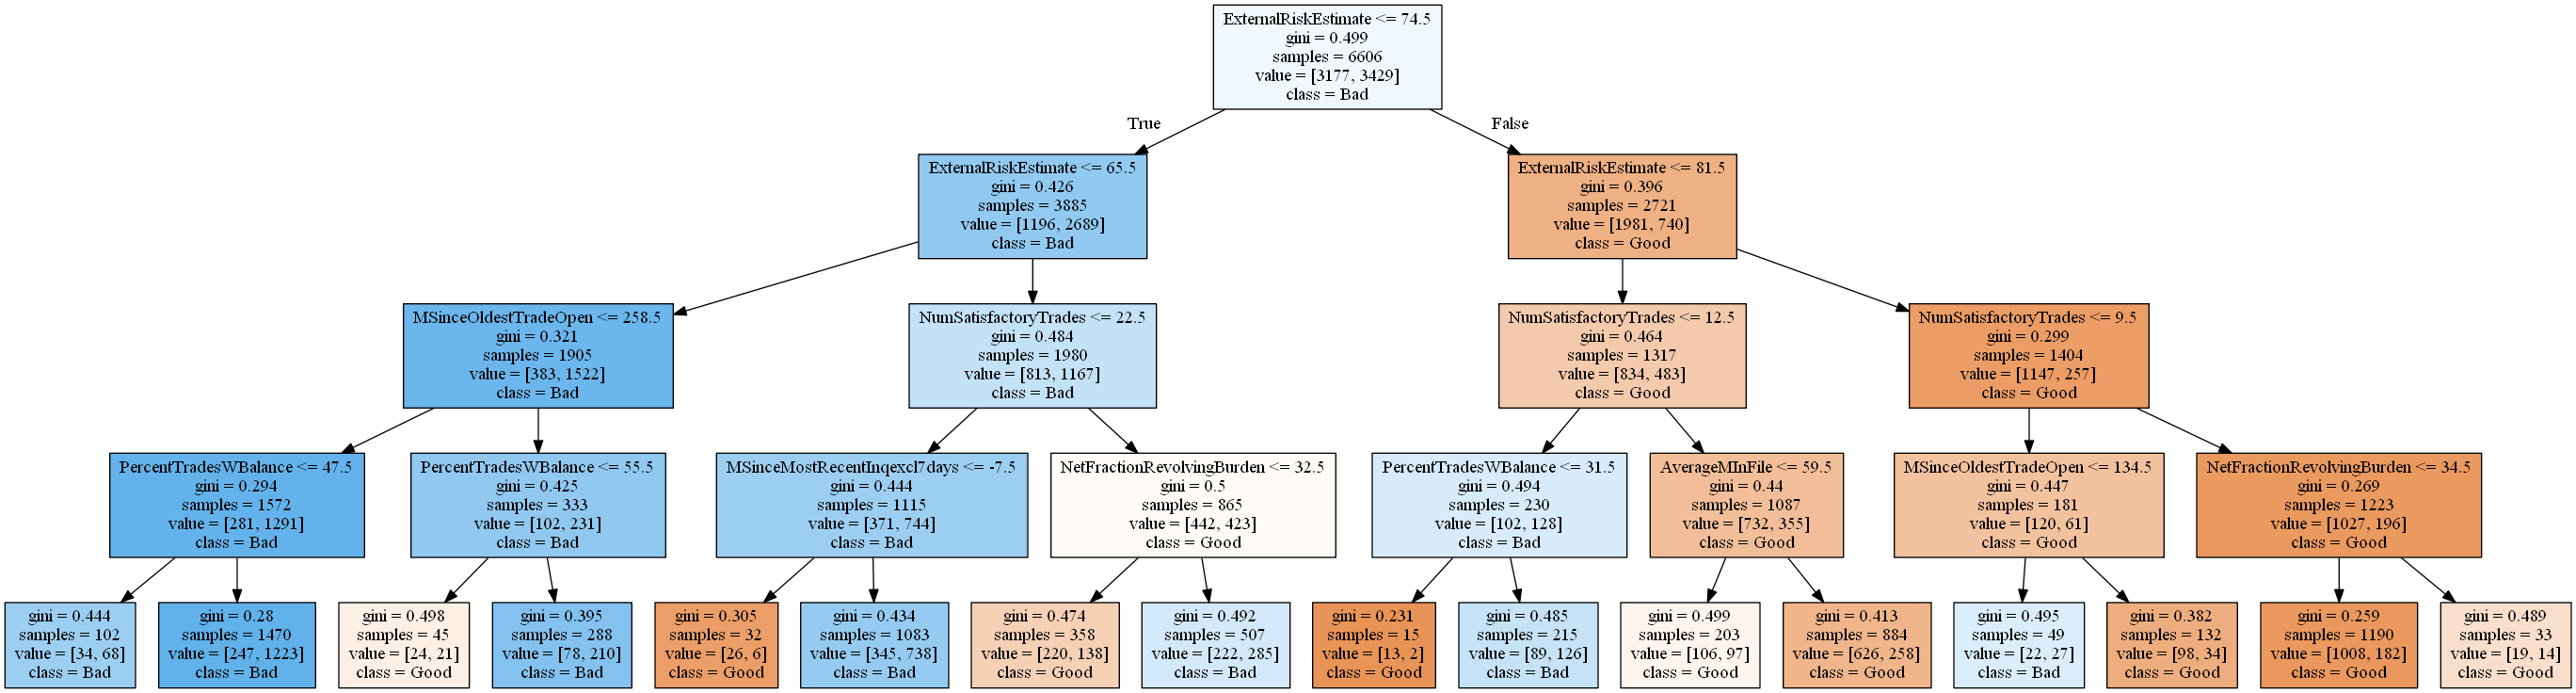

In [8]:
# Refit the model using tuned parameters
dtc = tree.DecisionTreeClassifier(max_depth=4)
dtc = dtc.fit(X_train, y_train)
dtc_predict = dtc.predict(X_test) # predictions
dtc_cv_score = cross_val_score(dtc, X, y, cv=10, scoring='roc_auc') #scores
model_summary(y_test, dtc_predict, dtc_cv_score) # Model summary

## Plot the tree
dot_data = tree.export_graphviz(dtc, feature_names=features, class_names=target_names, out_file=None, filled = True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**Notes on the decision tree model**
* The highest correlated variable ExternalRiskEstimate (consolidated version of risk markers) appears in the first and second nodes and has the exhibits the correct relationship with the predicted variable (monotonically decreasing)
* Other variables generally exhibit expected behaviors but of course deserve scrutiny.
* Overall model performance is very similar with depth parameter at 4 to 6. A simpler tree with depth of 4 may be preferred in this case.

### Random forest model
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.Random decision forests correct for decision trees’ habit of overfitting to their training set.

Again, let's first create a preliminary model and report its out-of-sample performance.

In [9]:
# Preliminary model fit
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train) #fit
rfc_predict = rfc.predict(X_test) # predictions
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc') #scores
model_summary(y_test, rfc_predict, rfc_cv_score) # Model summary

=== Confusion Matrix ===
[[1084  472]
 [ 385 1314]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1556
           1       0.74      0.77      0.75      1699

    accuracy                           0.74      3255
   macro avg       0.74      0.74      0.74      3255
weighted avg       0.74      0.74      0.74      3255



=== All AUC Scores ===
[0.79027562 0.78844133 0.81053909 0.77536483 0.79922852 0.81632317
 0.80631694 0.73769725 0.81396072 0.83024913]


=== Mean AUC Score ===
Mean AUC Score:  0.7968396591057277


Next we will try to optimize the model by searching for "best" hyperparameter settings.

In [10]:
# Model optimization
## Optimize select hyperparamaters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)] # number of trees in random forest
max_features = ['auto', 'sqrt'] # number of features at every split
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)] # max depth
max_depth.append(None)

## Create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

## Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, 
                                cv = 3, verbose=2, random_state=66, n_jobs = -1)
rfc_random.fit(X_train, y_train) # Fit the model
print(rfc_random.best_params_) # Print results

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.1min finished


{'n_estimators': 733, 'max_features': 'sqrt', 'max_depth': 260}


We then refit the model and report the most important features in the random forest model:

=== Confusion Matrix ===
[[1072  484]
 [ 371 1328]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1556
           1       0.73      0.78      0.76      1699

    accuracy                           0.74      3255
   macro avg       0.74      0.74      0.74      3255
weighted avg       0.74      0.74      0.74      3255



=== All AUC Scores ===
[0.79285415 0.79143537 0.80425017 0.77823523 0.80096353 0.81822921
 0.81206599 0.74129298 0.81649072 0.83269259]


=== Mean AUC Score ===
Mean AUC Score:  0.7988509936878191


,Gini-importance
ExternalRiskEstimate,0.125219
MSinceOldestTradeOpen,0.069055
MSinceMostRecentTradeOpen,0.041756
AverageMInFile,0.079348
NumSatisfactoryTrades,0.052211


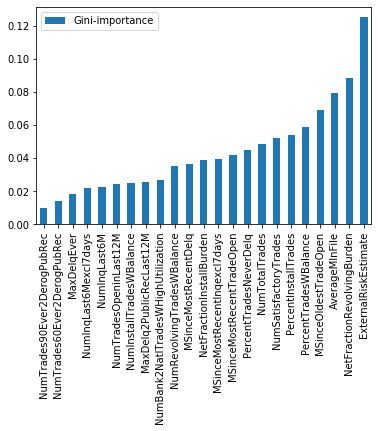

In [12]:
# Refit the model using tuned parameters
rfc = RandomForestClassifier(n_estimators=733, max_depth=260, max_features='sqrt')
rfc.fit(X_train,y_train) #fit
rfc_predict = rfc.predict(X_test) # predictions
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc') #scores
model_summary(y_test, rfc_predict, rfc_cv_score) # Model summary


# Feature Importance
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90) #Plot
importances.head() # Print the feature ranking

**Notes on the Random Forest Model**
* In this example we don't see much improvement in terms of out-of-sample performance compared to a simple tree model
* The most important variables are generally consistent with those in the simple tree model

More to come...